In [1]:
#uncomment to download cifar10 dataset from https://course.fast.ai/datasets (already in png format)
#!wget https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz && tar -xzf cifar10.tgz && rm cifar10.tgz

In [18]:
#training parameters:
bs = 512 #resnet34 w. bs 512 fits easily on Titan RTX (22GB of RAM); larger bs do not increase speed
img_dim_load = 128 # this is larger than the input 32x32; givings augmentations a larger chance to pad/augment
img_dim_cif = 96  # this is also larger than the input; giving model larger receptive field

In [19]:
import os, glob
def files_in_subdirs(start_dir, pattern = ["*.png","*.jpg","*.jpeg"]):
    files = []
    for p in pattern:
        for dir,_,_ in os.walk(start_dir):
            files.extend(glob.glob(os.path.join(dir,p)))
    return files
cifar10_train = files_in_subdirs('./cifar10/train')
cifar10_val = files_in_subdirs('./cifar10/test')
cifar10_paths = cifar10_val+cifar10_train
print("Loaded: ",len(cifar10_train), len(cifar10_val))

Loaded:  50000 10000


Using:  50000 10000 0


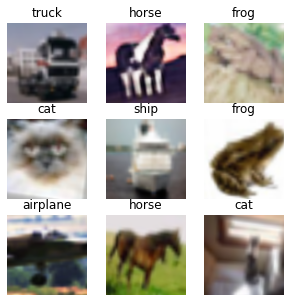

In [20]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


Using:  50000 10000 0


epoch,train_loss,valid_loss,accuracy,time
0,1.905196,0.747287,0.761200,00:17
1,0.860392,0.438750,0.860500,00:17
2,0.512578,0.338440,0.890400,00:17
3,0.396508,0.295029,0.900500,00:17
4,0.338385,0.277762,0.906800,00:17
5,0.298227,0.251110,0.915200,00:17
6,0.282164,0.240557,0.916800,00:17
7,0.268555,0.244126,0.917100,00:17
8,0.262503,0.232345,0.918600,00:17
9,0.253362,0.232543,0.919600,00:17


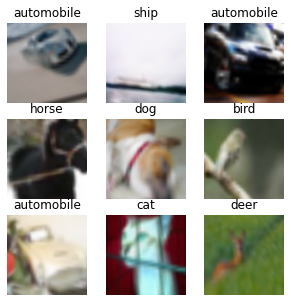

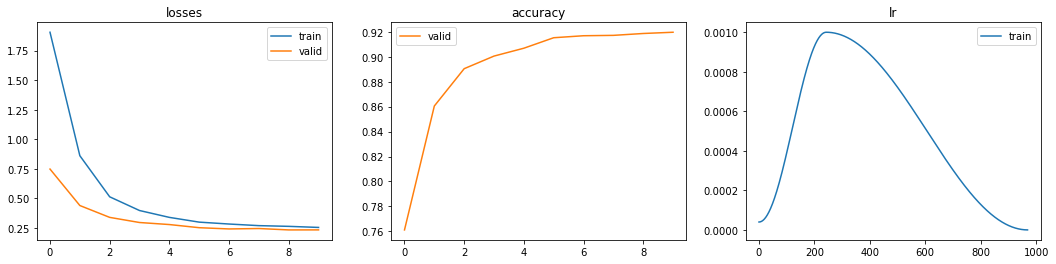

epoch,train_loss,valid_loss,accuracy,time
0,0.272829,0.283277,0.908300,00:20
1,0.324850,0.629512,0.806800,00:20
2,0.322268,0.424067,0.868000,00:20
3,0.280416,0.379657,0.875400,00:20
4,0.233184,0.312872,0.899700,00:20
5,0.184414,0.251429,0.919600,00:20
6,0.131442,0.192032,0.940000,00:20
7,0.091758,0.182719,0.943200,00:20
8,0.062854,0.159392,0.954300,00:20
9,0.043106,0.156109,0.953800,00:20


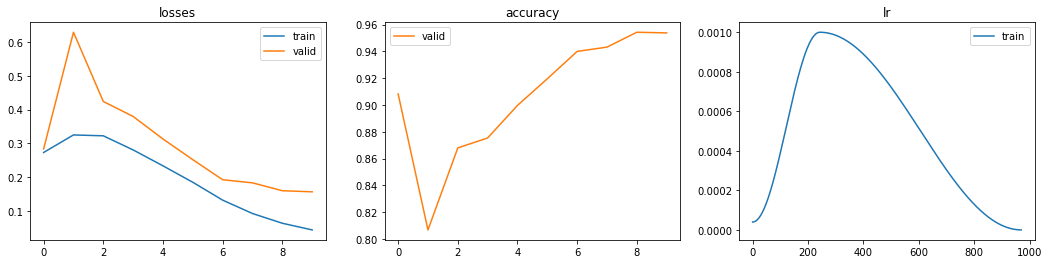

Accuracy (tta) : 0.9625999927520752


In [27]:
import torch
from torchvision.models import resnet34
from fastai2.vision.all import cnn_learner, accuracy, CSVLogger
from fastai2.vision.all import ProgressCallback
import fastai_metrics

from fastai2.data.transforms import RegexLabeller
from fastai2.vision.all import aug_transforms, Normalize, DataBlock, ImageBlock, CategoryBlock, Resize, IndexSplitter
from torchvision.transforms import RandomCrop, RandomHorizontalFlip
import matplotlib.pyplot as plt

def train_cifar10(cifar10_paths, 
                  idx_train=10000, # the first x cifar10_paths should be validation paths; remainder training
                  model=resnet34, 
                  epochs_per_pass = 10, 
                  bs = 512,  #resnet34 w. bs 512 fits easily on Titan RTX (22GB of RAM); larger bs do not increase speed
                  img_dim_load = 128,  # this is larger than the input 32x32; givings augmentations a larger chance to pad/augment
                  img_dim_cif = 96, # this is also larger than the input; giving model larger receptive field)
                  verbose = True):  

    get_cls = RegexLabeller(pat = r'.*/(.*)/')
    #default fastai augmentations (reflective padding, horizontal flipping, up to 10 deg rotation;)
    #see https://docs.fast.ai/vision.augment.html#aug_transforms
    #parameters based on https://gist.github.com/rlandingin/e09e2e568e964466fc3b5634bf18d87a
    tfms = [*aug_transforms(size=img_dim_cif, min_scale=0.8, max_zoom=1.1, max_lighting=0.4),
            Normalize.from_stats(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])]

    #creating a DataBlock 'from_folder' would work but we want to exclude or dublicate images later
    # (i.e. redundancy) -> this can be easily achived using file paths
    dblock = DataBlock(
      blocks=(ImageBlock, CategoryBlock),      # one image input and one categorical target
      splitter=IndexSplitter(range(0,idx_train)),
      batch_tfms=tfms,
      item_tfms=[Resize(img_dim_cif)],
      get_items = lambda x:(cifar10_paths),
      get_y     =  get_cls)
    ods_train = dblock.dataloaders('./',bs=bs)
    
    bad_valid = [t for t in ods_train.valid_ds.items if not '/test/' in t] #just a precaution to make sure validation frames are not in the training set
    assert len(bad_valid) == 0 or len(ods_train.valid_ds.items) != idx_train, "There are invalid validation frames in the dataloader"
    if verbose:
        print("Using: ", len(ods_train.train_ds.items), len(ods_train.valid_ds.items), len(bad_valid))
        ods_train.show_batch(max_n=9 , figsize=(5,5))
        plt.show()
    learn = cnn_learner(ods_train, model, metrics=accuracy, pretrained=True)
    if not verbose:
        learn.remove_cb(ProgressCallback) #necessary due to strange bug (see https://github.com/fastai/fastprogress/issues/72)
    learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1])
    learn.fit_one_cycle(epochs_per_pass) # per default all but the last two layers are frozen
    learn.recorder.plot_metrics()
    learn.unfreeze() # unfreezes all layers
    learn.fit_one_cycle(epochs_per_pass , max_lr=slice(1e-6,1e-4))
    if verbose:
        learn.recorder.plot_metrics()
    learn.remove_cb(ProgressCallback) #necessary due to strange bug (see https://github.com/fastai/fastprogress/issues/72)
    res = learn.tta(n=10)
    tta_acc = float(accuracy(*res))
    if verbose:
        print("Accuracy (tta) :", tta_acc)
    return tta_acc
        
tta_acc = train_cifar10(cifar10_paths)

This Accuracy is on par with the current best results at the paperswithcode public leaderboard:

https://paperswithcode.com/sota/image-classification-on-cifar-10

Best comparable entry (ResNet32) has 95.35